# Import

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

In [2]:
def normalizar_data(df):
    df = df.select_dtypes(include="number")
    return (df - df.min()) / (df.max() - df.min())

In [4]:
def wrangle(path):
    # Get data
    df = pd.read_csv(path)
    
    # Define variables to model
    variables = ["wind", "temp", "RH", "rain", "area"]
    df = df[variables]

    # Normalize data
    df = normalizar_data(df)

    # Add bias column
    df.insert(0, 'Bias', np.ones(df.shape[0]))

    return df

In [5]:
df = wrangle("forestfires.csv")
#df = pd.read_csv("/content/drive/MyDrive/forestfires.csv")
df.head()

,Bias,wind,temp,RH,rain,area
0,1.0,0.700000,0.192926,0.423529,0.00000,0.0
1,1.0,0.055556,0.508039,0.211765,0.00000,0.0
2,1.0,0.100000,0.398714,0.211765,0.00000,0.0
3,1.0,0.400000,0.196141,0.964706,0.03125,0.0
4,1.0,0.155556,0.295820,0.988235,0.00000,0.0


In [6]:
corr = df.iloc[:,1:].corr()
corr.style.background_gradient()

,wind,temp,RH,rain,area
wind,1.000000,-0.227116,0.069410,0.061119,0.012317
temp,-0.227116,1.000000,-0.527390,0.069491,0.097844
RH,0.069410,-0.527390,1.000000,0.099751,-0.075519
rain,0.061119,0.069491,0.099751,1.000000,-0.007366
area,0.012317,0.097844,-0.075519,-0.007366,1.000000


# Split
El dataset es separado en tres grupos:
- 70% para training
- 15% para testing
- 15% para validation

In [7]:
train_, validate_, test_ = np.split(df.sample(frac=1, random_state=42), [int(.7*len(df)), int(.85*len(df))])

In [8]:
def get_XY_data(matriz):
    X = matriz[matriz.columns[:-1]].to_numpy()
    y=matriz[matriz.columns[-1]].to_numpy()
    y=y.reshape(len(y),1)
    return X, y

X_TRAIN, Y_TRAIN = get_XY_data(train_)
X_VALIDATE, Y_VALIDATE = get_XY_data(validate_)
X_TEST, Y_TEST = get_XY_data(test_)

# Model

In [10]:
def h(x, w):
    return np.dot(x,w)

In [11]:
def Error(x,w,y,lamda,typo):
  if typo=="MSE":
    return np.sum((y-h(x,w))**2)/(2.0*len(x))
  if typo=="MAE":
    return np.sum(abs(y-h(x,w)))/(1.0*len(x))

In [12]:
def derivada(x,w,y,lamda,typo):
    n=len(x)
    if typo=="MSE":
      return (1/n)*(np.dot((y - h(x,w)).T,-1*x).T)
    if typo=="MAE":
      return (1.0/(1.0*len(x)))*np.dot(((y-h(x,w))/abs(y-h(x,w))).T,-1*x).T


In [13]:
def update(w,  dw, alpha):
    w = w - alpha*dw 
    return w

In [14]:
def train1(x,y,alfa,lamda,epochs,typo):
    w = np.array([np.random.rand() for i in range(x.shape[1])])
    w= w.reshape(len(w),1)
    l = Error(x,w,y,lamda,typo)
    loss = []
    for i in range(epochs):
        dw = derivada(x, w, y,lamda,typo)
        w = update(w,dw,alfa)
        l = Error(x, w,y,lamda,typo)
        loss.append(l)
    return w, loss


def Plot_Loss(epochs,loss, label = "Data"):
   plt.plot(epochs, loss, label = label)
   plt.xlabel("Epochs")
   plt.legend()


In [15]:
def get_data(data, batch_size):
    indices = np.random.choice(data.shape[0], batch_size, replace=False)
    X_DATA = np.array(data.iloc[indices, :-1])
    Y_DATA = np.array(data.iloc[indices, -1])
    Y_DATA=Y_DATA.reshape(len(Y_DATA),1)
    return X_DATA, Y_DATA

In [16]:
def train_complete(x,y,alfa,lamda,epochs,typo,batch_size_train,batch_size_validate):
    w = np.array([np.random.rand() for i in range(x.shape[1])])
    w= w.reshape(len(w),1)
    loss_training = []
    loss_validation = []
    loss_test=[]
    #print("-------")
    for i in range(epochs):
        x_train,y_train=get_data(train_,batch_size_train) 
        dw=derivada(x_train,w,y_train,lamda,typo)
        w = update(w,dw,alfa)
        lt=Error(x_train,w,y_train,lamda,typo)
        x_validate,y_validate=get_data(validate_,batch_size_validate)
        lv=Error(x_validate,w,y_validate,lamda,typo)
        ls=Error(X_TEST,w,Y_TEST,lamda,typo)
        loss_training.append(lt)
        loss_validation.append(lv)
        loss_test.append(ls)
    return w,loss_training,loss_validation,loss_test

In [17]:
def Plot_Loss_both(epochs,loss_training,loss_validation):
    plt.plot(epochs, loss_validation, label= "Loss Validation")
    plt.plot(epochs, loss_training, label= "Loss training")
    plt.legend()
    plt.xlabel("Epochs")
    plt.title("Loss Validation vs Loss Training")
    plt.show()

## Mean Absolute Error y Batch Gradient Descent

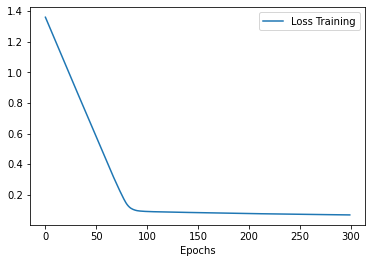

In [18]:
epochs=300
typo="MAE"
w,loss=train1(X_TRAIN,Y_TRAIN,0.01,2,epochs,typo)
Plot_Loss([i for i in range(epochs)],loss, "Loss Training")

## Mean Squared Error y Batch Gradient Descent

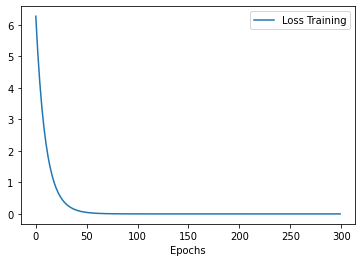

In [43]:
epochs=300
typo="MSE"
w,loss_training=train1(X_TRAIN,Y_TRAIN,0.01,2,epochs,typo)
Plot_Loss([i for i in range(epochs)], loss_training, "Loss Training")

## Mean Absolute Error y Mini Batch

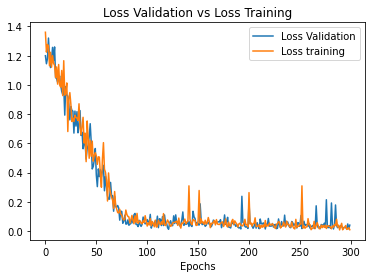

In [44]:
epochs=300
typo="MAE"
w,loss_training,loss_validation,loss_test = train_complete(X_TRAIN, Y_TRAIN, 0.01,0,epochs,typo,4,4)
Plot_Loss_both([i for i in range(epochs)],loss_training,loss_validation)

## Mean Squared Error y Mini Batch

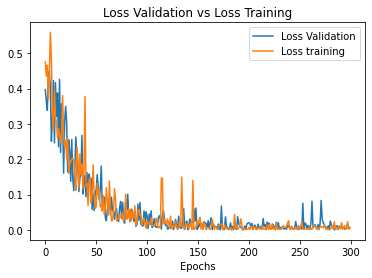

In [45]:
epochs=300
typo="MSE"
w,loss_training,loss_validation,loss_test = train_complete(X_TRAIN, Y_TRAIN, 0.01,0,epochs,typo,4,4)
Plot_Loss_both([i for i in range(epochs)],loss_training,loss_validation)

In [46]:
def r_coef(w):
   r2= 1 - np.sum((Y_TEST - np.dot(w.T,X_TEST.T))**2) / np.sum((Y_TEST - Y_TEST.mean())**2)
   return r2

In [57]:
learning_rate=[0.5,0.1,0.01,0.001, 0.0001, 0.00001]
epochs_array=[300]
error_type=["MAE","MSE"]

dicc_loss = {
    0.5 : None,
    0.1 : None,
    0.01 : None,
    0.001 : None,
    0.0001 : None,
    0.00001 : None
}

dicc_validation = {
    0.5 : None,
    0.1 : None,
    0.01 : None,
    0.001 : None,
    0.0001 : None,
    0.00001 : None
}

dicc_test = {
    0.5 : None,
    0.1 : None,
    0.01 : None,
    0.001 : None,
    0.0001 : None,
    0.00001 : None
}

for i in learning_rate:
  for j in epochs_array:
    #for k in error_type:
      w, loss_training, loss_validation, loss_test = train_complete(X_TRAIN, Y_TRAIN, i, 0, j, "MSE", 32, 32)
      dicc_loss[i] = loss_training
      dicc_validation[i] = loss_validation
      dicc_test[i] = loss_test


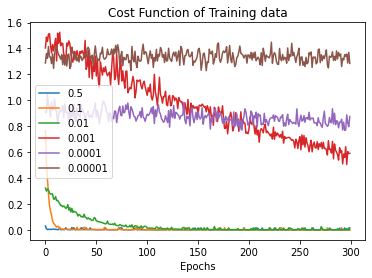

In [58]:
legends = ["0.5", "0.1", "0.01", "0.001", "0.0001", "0.00001"]
j = 0
for learning_rate, history in dicc_loss.items():
    plt.plot([i for i in range(len(history))], history, label = legends[j])
    j+=1
plt.title("Cost Function of Training data")
plt.xlabel("Epochs")
plt.legend()
plt.show()

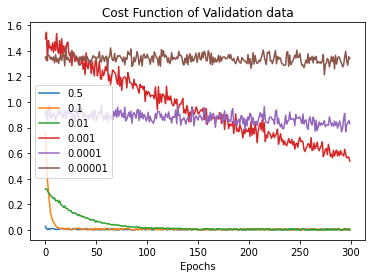

In [59]:
legends = ["0.5", "0.1", "0.01", "0.001", "0.0001", "0.00001"]
j = 0
for learning_rate, history in dicc_validation.items():
    plt.plot([i for i in range(len(history))], history, label = legends[j])
    j+=1
plt.title("Cost Function of Validation data")
plt.xlabel("Epochs")
plt.legend()
plt.show()

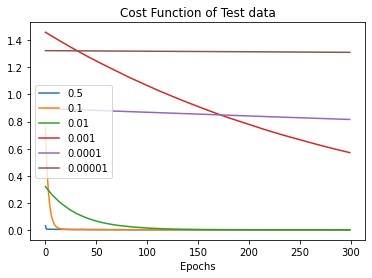

In [60]:
legends = ["0.5", "0.1", "0.01", "0.001", "0.0001", "0.00001"]
j = 0
for learning_rate, history in dicc_test.items():
    plt.plot([i for i in range(len(history))], history, label = legends[j])
    j+=1
plt.title("Cost Function of Test data")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [55]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_TRAIN,Y_TRAIN)
print(f'Score: {round(lr.score(X_TEST,Y_TEST))}')


-0.04025390729357281